In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import pickle

In [36]:
# Reading the CSV file without headers
file_path = '/content/ExtractedExpense_BPS.csv'
df = pd.read_csv(file_path, header=None)

df = df.transpose()
df.columns = df.iloc[0]
df = df[1:]

df.reset_index(drop=True, inplace=True)

df = df.apply(pd.to_numeric)

df.head()

,Income Lower,Income Upper,Food Lower,Food Upper,Household Lower,Household Upper,Education Lower,Education Upper,Health Lower,Health Upper,Transportation Lower,Transportation Upper,Apparel Lower,Apparel Upper,Social Life Lower,Social Life Upper,Entertainment Lower,Entertainment Upper,Other Lower,Other Upper
0,150000.0,199999.0,67.86,80.49,13.17,33.56,5.97,7.96,1.10,0.14,9.48,12.64,2.59,3.45,0.04,0.05,1.04,1.05,0.05,0.07
1,200000.0,299999.0,54.36,81.53,18.26,33.39,7.91,10.86,1.18,1.76,7.11,10.67,1.82,2.73,0.06,1.09,2.03,3.05,0.47,0.71
2,300000.0,499999.0,53.12,88.53,19.66,32.76,8.09,11.49,1.15,1.92,7.18,11.97,1.73,2.89,0.17,1.29,2.09,3.14,0.52,0.86
3,500000.0,749999.0,51.13,76.69,19.85,29.77,8.15,11.23,1.26,1.89,7.57,11.36,1.77,2.65,0.23,2.34,3.11,4.17,0.69,1.04
4,750000.0,999999.0,50.28,67.04,21.71,28.95,8.46,11.28,1.38,1.84,8.49,11.31,2.03,2.70,0.29,2.39,3.15,4.20,1.06,1.41


In [37]:
def generate_data(df, num_samples=10000):
    augmented_data = []

    for i in range(num_samples):
        row = df.sample(n=1).to_dict('records')[0]
        new_row = {}
        new_row['Income'] = np.random.uniform(row['Income Lower'], row['Income Upper'])

        total_percentage = 0
        for col in df.columns[2::2]:  # Iterate through the categories
            lower_bound = row[col]
            upper_bound = row[col.replace('Upper', 'Lower')]
            value = np.random.uniform(lower_bound, upper_bound)
            new_row[col.replace(' Lower', '')] = value
            total_percentage += value

        # Adjust percentages to ensure the total is not more than 100
        if total_percentage > 100:
            scale_factor = 100 / total_percentage
            for key in new_row.keys():
                if key != 'Income':
                    new_row[key] *= scale_factor

        augmented_data.append(new_row)

    return pd.DataFrame(augmented_data)

In [38]:
augmented_df = generate_data(df)

In [39]:
augmented_df

,Income,Food,Household,Education,Health,Transportation,Apparel,Social Life,Entertainment,Other
0,5.964746e+05,51.130000,19.850000,8.150000,1.260000,7.570000,1.770000,0.230000,3.110000,0.690000
1,3.984039e+06,40.240000,16.430000,7.970000,4.350000,7.960000,2.260000,0.820000,5.410000,2.610000
2,1.547567e+05,66.989141,13.000987,5.893386,1.085884,9.358342,2.556762,0.039487,1.026654,0.049358
3,1.482519e+06,44.620000,21.690000,8.400000,1.490000,8.650000,2.010000,0.390000,4.200000,1.420000
4,7.721609e+05,50.280000,21.710000,8.460000,1.380000,8.490000,2.030000,0.290000,3.150000,1.060000
...,...,...,...,...,...,...,...,...,...,...
9995,6.778091e+05,51.130000,19.850000,8.150000,1.260000,7.570000,1.770000,0.230000,3.110000,0.690000
9996,9.532474e+05,50.280000,21.710000,8.460000,1.380000,8.490000,2.030000,0.290000,3.150000,1.060000
9997,1.687771e+05,66.989141,13.000987,5.893386,1.085884,9.358342,2.556762,0.039487,1.026654,0.049358
9998,5.657816e+05,51.130000,19.850000,8.150000,1.260000,7.570000,1.770000,0.230000,3.110000,0.690000


In [40]:
# Define features
features = ['Income', 'Food', 'Household', 'Education', 'Health', 'Transportation', 'Apparel', 'Social Life', 'Entertainment', 'Other']

# Assuming augmented_df is already defined
train_df = augmented_df.sample(frac=0.8, random_state=42)
val_df = augmented_df.drop(train_df.index)

# Initialize and fit the scaler
scaler = MinMaxScaler()
train_df['Income'] = scaler.fit_transform(train_df[['Income']])
val_df['Income'] = scaler.transform(val_df[['Income']])

# Save the scaler to a file
scaler_filename = 'scaler.pkl'
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)

# Define input and output data for training and validation
X_train = train_df[['Income']]
y_train = train_df[features[1:]]  # Exclude 'Income'
X_val = val_df[['Income']]
y_val = val_df[features[1:]]  # Exclude 'Income'

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(1,)),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(features) - 1)  # Linear activation by default for the output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=2
)

# Save the trained model
model.save('model.h5')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                128       
                                                                 
 dense_17 (Dense)            (None, 128)               8320      
                                                                 
 dense_18 (Dense)            (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 9)                 2313      
                                                                 
Total params: 43785 (171.04 KB)
Trainable params: 43785 (171.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
250/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


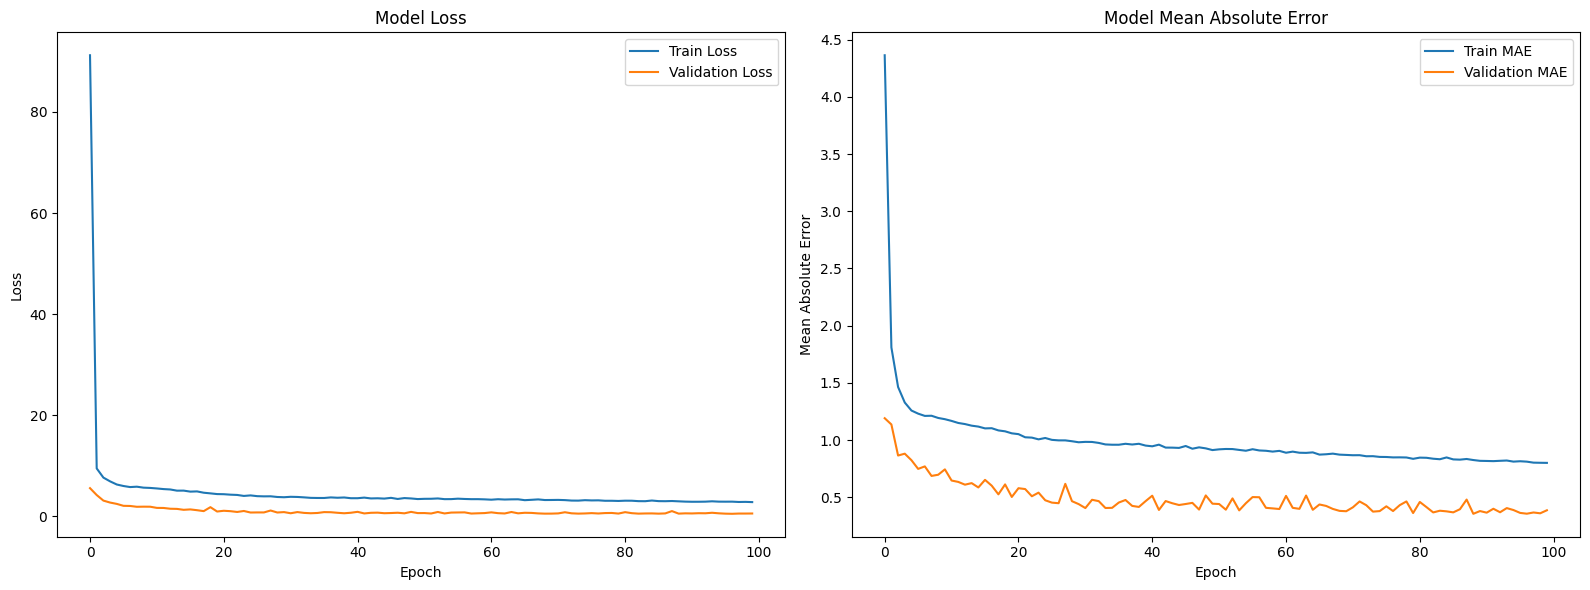

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right')

ax2.plot(history.history['mae'], label='Train MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title('Model Mean Absolute Error')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean Absolute Error')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [43]:
income = 4799999  # Example income
X_input = pd.DataFrame({'Income': [income]})

# Normalize the input
X_input['Income'] = scaler.transform(X_input[['Income']])

# Make predictions
predicted_percentages = model.predict(X_input)

# Scale the predicted percentages to sum to 100%
predicted_percentages = predicted_percentages[0] / predicted_percentages[0].sum() * 100

# Display predicted percentages
for i, category in enumerate(features[1:]):  # Exclude 'Income'
    print(f"{category}: {predicted_percentages[i]:.2f}%")

1/1 [==============================] - 0s 46ms/step
Food: 46.62%
Household: 18.62%
Education: 9.00%
Health: 4.45%
Transportation: 9.24%
Apparel: 2.60%
Social Life: 0.84%
Entertainment: 5.88%
Other: 2.74%
